In [270]:
import torch
torch.cuda.is_available()

True

In [271]:
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [272]:
dataset = MNIST(root='data/', download=True, train=True, transform=ToTensor())
test_dataset = MNIST(root='data/', download=True, train=False, transform=ToTensor())

image.shape: torch.Size([1, 28, 28])
Label: 5


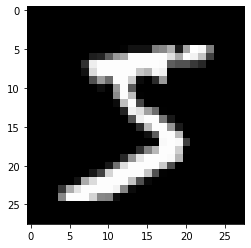

In [273]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


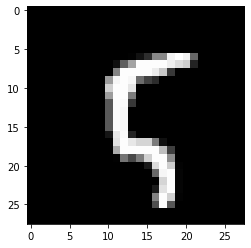

In [274]:
image, label = dataset[100]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

In [275]:
val_size = 10000
train_size = len(dataset) - val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [276]:
from collections import Counter
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size, num_workers=0, pin_memory=True)
print([[x, dict(Counter(i.item() for i in test_dataset.targets))[x]] for x in sorted(dict(Counter(i.item() for i in test_dataset.targets)))])
test_dataset.class_to_idx

[[0, 980], [1, 1135], [2, 1032], [3, 1010], [4, 982], [5, 892], [6, 958], [7, 1028], [8, 974], [9, 1009]]


{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

images.shape: torch.Size([128, 1, 28, 28])


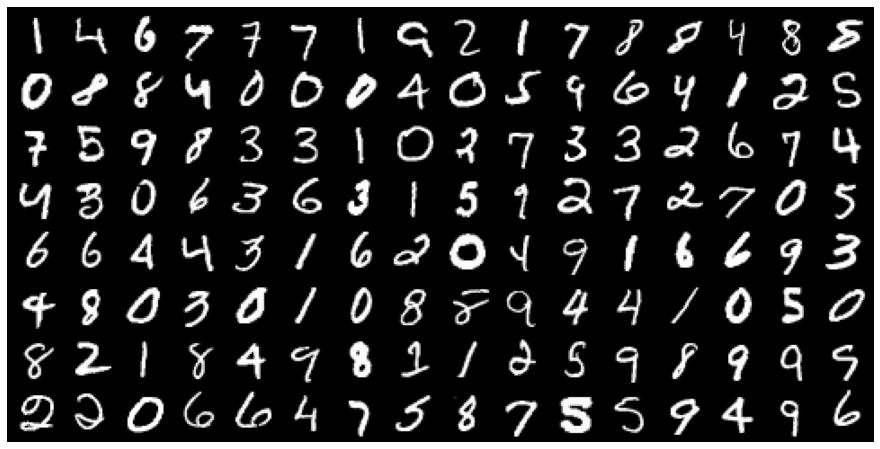

In [277]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1,2,0)))
    break

In [278]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [279]:
input_size = inputs.shape[-1]
hidden_size = 32

In [280]:
layer1 = nn.Linear(input_size, hidden_size)
inputs.shape

torch.Size([128, 784])

In [281]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [282]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [283]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

In [284]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [285]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.701805055141449
min(relu_outputs): 0.0


In [286]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [287]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [288]:
inputs.shape

torch.Size([128, 784])

In [289]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3188, grad_fn=<NllLossBackward0>)

In [290]:
#manual layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [291]:
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [292]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

torch.allclose(outputs2, outputs3, 1e-3)

True

In [293]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # hidden layer 2
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        # output layer
        self.linear3 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten
        xb = xb.view(xb.size(0), -1)
        # Intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Activation function
        out = F.relu(out)
        # Get preds using hidden layer
        out = self.linear2(out)
        # Activation function
        out = F.relu(out)
        # Get preds using output layer
        out = self.linear3(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss' : loss, 'val_acc':acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

def accuracy(outs, labels):
    _, preds = torch.max(outs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item() / len(preds))

In [294]:
input_size = 784
hidden_size = 64
num_classes = 10

In [295]:
model = MnistModel(input_size, hidden_size, num_classes)

In [296]:
for t in model.parameters():
    print(t.shape)

torch.Size([64, 784])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [297]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape:', outputs.shape)
print('Sample outputs:\n', outputs[:2].data)

Loss: 2.3182497024536133
outputs.shape: torch.Size([128, 10])
Sample outputs:
 tensor([[-0.0475, -0.0228,  0.0913, -0.0033,  0.0342, -0.1681,  0.0793,  0.0861,
          0.0283, -0.0890],
        [-0.0697,  0.0190,  0.0998, -0.0139,  0.1016, -0.1180,  0.0876,  0.0784,
          0.0606, -0.0832]])


In [298]:
torch.cuda.is_available()

True

In [299]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [300]:
device = get_default_device()
device

device(type='cuda')

In [301]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device)

In [302]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [303]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [304]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [305]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([2, 8, 1, 8, 0, 2, 5, 2, 4, 9, 1, 0, 1, 6, 1, 8, 6, 3, 6, 5, 1, 2, 3, 5,
        2, 5, 2, 8, 3, 5, 9, 8, 9, 6, 5, 3, 4, 9, 5, 7, 5, 7, 0, 1, 2, 7, 2, 1,
        1, 4, 8, 6, 4, 1, 4, 6, 2, 5, 9, 7, 6, 6, 6, 7, 8, 0, 6, 4, 1, 7, 8, 5,
        8, 3, 9, 5, 4, 9, 3, 7, 5, 6, 2, 9, 6, 4, 8, 0, 7, 1, 1, 0, 8, 8, 0, 7,
        6, 6, 7, 3, 2, 3, 9, 8, 0, 1, 3, 0, 4, 5, 1, 5, 9, 5, 5, 8, 7, 9, 2, 4,
        1, 0, 5, 2, 9, 9, 5, 1, 9, 2, 0, 8, 6, 8, 1, 4, 6, 2, 4, 4, 9, 1, 5, 4,
        7, 1, 1, 5, 8, 7, 9, 8, 7, 3, 7, 2, 5, 9, 5, 1, 7, 5, 2, 1, 8, 6, 7, 5,
        0, 2, 6, 8, 6, 7, 6, 7, 3, 2, 9, 8, 1, 8, 7, 7, 4, 9, 6, 8, 6, 2, 9, 8,
        3, 9, 3, 1, 3, 4, 6, 5, 1, 1, 3, 1, 5, 8, 8, 2, 8, 6, 0, 7, 3, 5, 5, 1,
        1, 1, 4, 0, 1, 7, 6, 5, 1, 3, 1, 2, 3, 7, 3, 9, 3, 4, 2, 2, 6, 3, 2, 6,
        1, 1, 0, 2, 3, 8, 7, 2, 8, 9, 0, 6, 3, 9, 5, 1], device='cuda:0')


In [325]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    model_history = {}
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if not (epoch % 10):
            model_history[str(epoch)] = model.state_dict()
            print("Saved model")
    return history, model_history

In [326]:
model = MnistModel(input_size, hidden_size, num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [327]:
history = [evaluate(model, val_loader)]
history[0]['train_loss'] = 2.311

In [328]:
history_new, model_history = fit(50, 0.001, model, train_loader, val_loader, opt_func=torch.optim.Adam)
history = history + history_new

Epoch [0], val_loss: 0.2477, val_acc: 0.9302
Saved model
Epoch [1], val_loss: 0.1818, val_acc: 0.9479
Epoch [2], val_loss: 0.1466, val_acc: 0.9567
Epoch [3], val_loss: 0.1302, val_acc: 0.9624
Epoch [4], val_loss: 0.1198, val_acc: 0.9643
Epoch [5], val_loss: 0.1131, val_acc: 0.9668
Epoch [6], val_loss: 0.1039, val_acc: 0.9717
Epoch [7], val_loss: 0.1058, val_acc: 0.9689
Epoch [8], val_loss: 0.0959, val_acc: 0.9731
Epoch [9], val_loss: 0.0959, val_acc: 0.9729
Epoch [10], val_loss: 0.1066, val_acc: 0.9709
Saved model
Epoch [11], val_loss: 0.1023, val_acc: 0.9705
Epoch [12], val_loss: 0.0951, val_acc: 0.9731
Epoch [13], val_loss: 0.0950, val_acc: 0.9736
Epoch [14], val_loss: 0.0918, val_acc: 0.9750
Epoch [15], val_loss: 0.0936, val_acc: 0.9751
Epoch [16], val_loss: 0.0934, val_acc: 0.9734
Epoch [17], val_loss: 0.0931, val_acc: 0.9745
Epoch [18], val_loss: 0.1000, val_acc: 0.9734
Epoch [19], val_loss: 0.0995, val_acc: 0.9753
Epoch [20], val_loss: 0.1189, val_acc: 0.9718
Saved model
Epoch [2

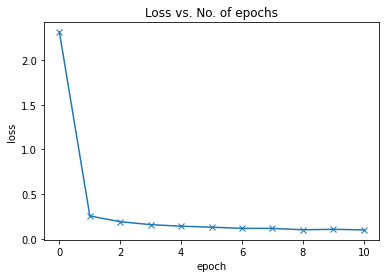

In [310]:
from imp import reload
reload(plt)
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

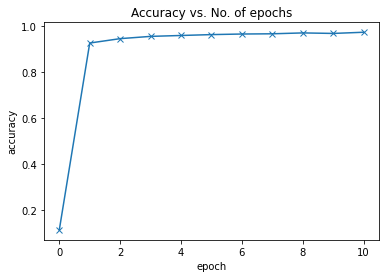

In [311]:
reload(plt)
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

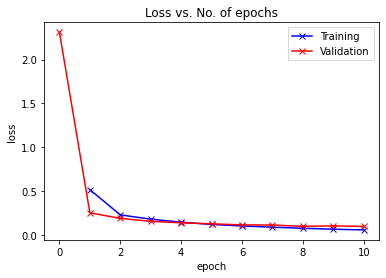

In [312]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
plot_losses(history)

In [313]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


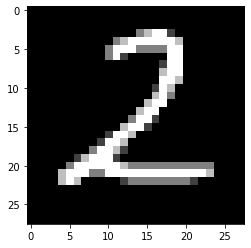

In [314]:
reload(plt)
img, label = val_ds[100]
plt.imshow(img[0], cmap="gray")
print("Label:", label, ', Predicted:', predict_image(to_device(img, device), model))

Label: 6 , Predicted: 6


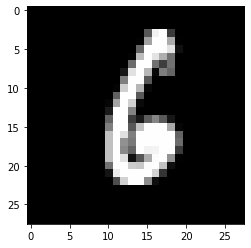

In [315]:
img, label = val_ds[9830]
plt.imshow(img[0], cmap="gray")
print("Label:", label, ', Predicted:', predict_image(to_device(img, device), model))

Label: 1 , Predicted: 8


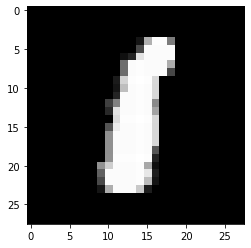

In [316]:
img, label = val_ds[1210]
plt.imshow(img[0], cmap="gray")
print("Label:", label, ', Predicted:', predict_image(to_device(img, device), model))

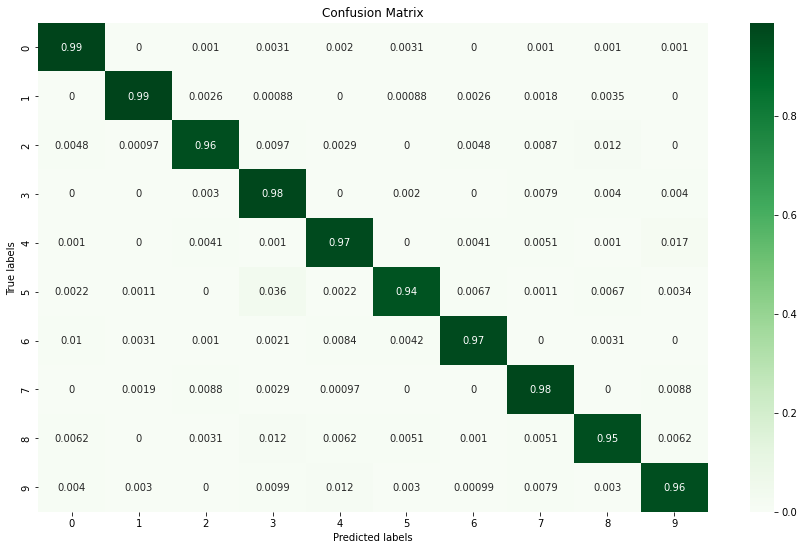

In [317]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

y_preds = []
y_true = []

for inputs, labels in test_loader:
    output = model(inputs)
    _, preds = torch.max(output, dim=1)
    y_preds.extend([pred.item() for pred in preds])
    y_true.extend([label.item() for label in labels])
reload(plt)
classes = [str(i) for i in range(0,10)]
cf_matrix = confusion_matrix(y_true, y_preds)
sums = [dict(Counter(i.item() for i in test_dataset.targets))[x] for x in sorted(dict(Counter(i.item() for i in test_dataset.targets)))]
df_cm = pd.DataFrame(cf_matrix/[[x for i in range(0,10)] for x in sums], index = [i for i in classes],
                     columns = [i for i in classes])
ax= plt.subplot()
sn.heatmap(df_cm, annot=True, ax=ax, cmap="Greens")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.gcf().set_size_inches(15, 9)

In [329]:
result = evaluate(model, test_loader)
print(result['val_acc'])

0.9760680198669434


In [333]:
torch.save(model.state_dict(), 'mnist-deep-network.pth')

In [332]:
model.state_dict()

AttributeError: 'collections.OrderedDict' object has no attribute 'shape'